# Enhanced Interactive Labeling and Model Training Using AI Assistance

This notebook introduces an advanced approach to interactive data labeling, leveraging AI assistance to augment the manual labeling process. The core idea is to iteratively refine a model's understanding and predictive accuracy by incorporating real-time user feedback. As you engage in labeling your dataset, the model learns from your inputs, enhancing its ability to make more accurate predictions over time. Key functionalities developed in this notebook, using a CSV file and integrated AI APIs, include:

1. Selective Transcript Retrieval: Implement a feature to extract a specific number of consecutive lines from a transcript, along with their corresponding labels. This selective retrieval allows for focused and efficient data processing.

2. Mislabeled Data Correction and Accuracy Assessment: Introduce a mechanism to identify and correct mislabeled instances in the dataset. This component not only corrects errors but also calculates the accuracy of the model's predictions, providing valuable insights into its performance.

3. Incremental Model Training: Develop a system that utilizes the corrected labels as additional training data. This process enables the model to learn from its mistakes and apply this new knowledge to future predictions, progressively improving its accuracy.

4. Dynamic Batch Sizing: Design an adaptive approach to determine the size of data batches for processing. This method conditions the batch sizes on the accuracy of the model's recent predictions, optimizing the balance between efficiency and the need for user intervention.

Overall, this notebook serves as a comprehensive guide to building a sophisticated, AI-assisted labeling workflow that not only aids in the manual labeling process but also evolves the model's capabilities through continuous learning and adaptation.

In [1]:
# Importing necessary libraries 
import os
import getpass
import pandas as pd
from openai import OpenAI
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
from ai_assisted_coding_final import assistant
from ai_assisted_coding_final.interactive_labeling import *

The next block of code will ask you to input your API Key. If you do not have one, please go to [make an account](https://platform.openai.com/docs/quickstart?context=python) and then set up an API key [here](https://platform.openai.com/api-keys). This functionality does cost money so you will need to pay for usage before proceeding.

In [2]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:
from openai import OpenAI
client = OpenAI()

## Instantiating Assistant

In [4]:
assistant_manager = assistant.OpenAIAssistantManager(client)

The code block below will create a Custom Teacher Utterances Classifier Assistant that will leverage Generative AI to aid you in labeling. You have to options:

1. Running the first code block will run your assistant using the GPT-4 Turbo with vision model, which costs costs $0.01/1k prompt tokens
2. Running the second, will run your assistant using GPT-3.5 Turbo, which costs 0.003/1K input 

If you get an erroe saying that 'gpt-4-1106-preview' is not available, please use option 2. 

In [5]:
#assistant_manager.create_assistant()

asst_84GjzBJ39lnRZh4pFoH55ZGg


Assistant(id='asst_84GjzBJ39lnRZh4pFoH55ZGg', created_at=1702323990, description='A tool for classifying teacher utterances into the categories OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral).', file_ids=[], instructions="You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That's right, 'he' is a pronoun because it can take the place of a noun.\n                                            assistant: PRS\n                                            user: You need 

In [161]:
#assistant_manager.create_custom_assistant()

When you create an assistant it will print its assistant id. Please save this and run the code below to retrieve your assistant once you restart the kernel or come back to this notebook. This will allow you to use the same assistant, instead of creating a new one every single time you want to access the functionality in this notebook. 

In [5]:
assistant_manager.retrieve_assistant("asst_84GjzBJ39lnRZh4pFoH55ZGg")

Assistant(id='asst_84GjzBJ39lnRZh4pFoH55ZGg', created_at=1702323990, description='A tool for classifying teacher utterances into the categories OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral).', file_ids=[], instructions="You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That's right, 'he' is a pronoun because it can take the place of a noun.\n                                            assistant: PRS\n                                            user: You need 

## User Inputs 

In [17]:
file_path = "data/231-3.csv"  # This is the path to the file you want to label
num_manual_labels = 5 # This is the number of manual labels you want to start with
initial_batch_size = 5 # This is the number of examples you want to start with

In [12]:
# Read data
lines = read_csv(file_path)
initial_data = lines[:num_manual_labels]  # Adjust as needed
unlabeled_data = lines[num_manual_labels:]

In [18]:
all_labeled_data = []
context = ""
accuracy_scores = []
batch_sizes = []
batch_size = initial_batch_size

## Initial Labeling

The block below will print out 5 labels that you need to manually label. 

In [14]:
# Display all lines first
for data in initial_data:
    print(f"Line to label: {data}")

Line to label: Good morning class, today we are going to learn about ancient civilizations.
Line to label: Can anyone tell me what a civilization is?
Line to label: Yes, that's right. A civilization is a complex society with its own government, religion, and economy.
Line to label: Now, let's talk about the first civilization we know of, the Sumerians.
Line to label: They lived in a region called Mesopotamia. Can anyone find Mesopotamia on the map?


Now you will be given the option to label these five initial utterances. When you run the next code block you will be asked to input the correct label for each label in order. Depending on your integrated development environment, the input box may appear in different locations. In VSCode, you will see a box appear at the top of the screen. Please the labels one at a time, in the order they appear above. 

In [15]:
# Then collect labels for each line
context = "Here are more examples of how to classify utterances:"
all_labeled_data = []

for data in initial_data:
    label = label_data(data)
    context += f"\nuser: '{data}'\nassistant: '{label}'"
    all_labeled_data.append((data, label))
context += "\nI am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU"


Now that you have manually inputted 5 labels, we can provide these examples to our Custom Teacher Utterances Classifier Assistant as context. The code block below is used for batch processing unlabeled data. It processes each batch, gets predictions, allows user input for verification or correction, and calculates batch accuracy.

## In the Loop Labeling

In [19]:
i = 0
while i < len(unlabeled_data):
    batch, actual_batch_size = process_batch(unlabeled_data, i, batch_size, batch_sizes)
    labeled_data, correct_responses = get_user_labels(batch, assistant_manager, context)
    all_labeled_data.extend(labeled_data)

    accuracy = correct_responses / actual_batch_size  # Use actual_batch_size here
    accuracy_scores.append(accuracy)

    batch_size = increase_batch_size(batch_size, accuracy)
    i += actual_batch_size

Predicted for 'Good job, Sarah! Mesopotamia is between the Tigris and Euphrates rivers.': PRS
Predicted for 'The Sumerians invented many things we still use today. Can anyone give me an example?': OTR
Predicted for 'Excellent, they did invent the wheel!': PRS
Predicted for 'They also invented writing. They wrote on clay tablets using a script called cuneiform.': NEU
Predicted for 'Jack, please stop talking while I am teaching.': REP
Predicted for 'Let's move on to the ancient Egyptians.': NEU
Predicted for 'They built incredible structures called pyramids. Does anyone know why they built these?': OTR
Predicted for 'That's correct, they built them as tombs for their pharaohs.': PRS
Predicted for 'Can anyone tell me about a famous pharaoh?': OTR
Predicted for 'Yes, King Tutankhamun is a very famous pharaoh.': PRS
Predicted for 'The ancient Egyptians also invented paper using a plant called papyrus.': NEU
Predicted for 'Now, let's talk about the ancient Greeks.': NEU
Predicted for 'They a

## Accuracy and Batch Size Summary

In [20]:
accuracy_scores

[1.0, 0.7, 1.0, 0.9, 1.0, 1.0, 0.7, 1.0, 0.625]

In [22]:
accuracy_scores

[1.0, 0.7, 1.0, 0.9, 1.0, 1.0, 0.7, 1.0, 0.625]

In [23]:
batch_sizes

[5, 10, 5, 10, 5, 10, 10, 5, 8]

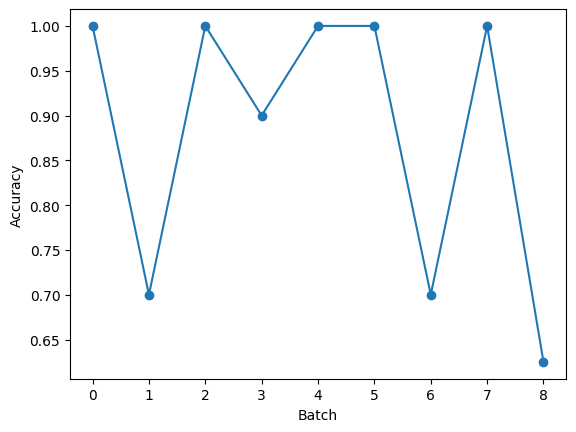

In [24]:
# plot accuracy scores against batch number (i.e index)
# make it a point at each value and then lines connecting them
plt.plot(accuracy_scores, 'o-')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.xticks(range(len(accuracy_scores)))
plt.show()

In [25]:
batch_sizes

[5, 10, 5, 10, 5, 10, 10, 5, 8]

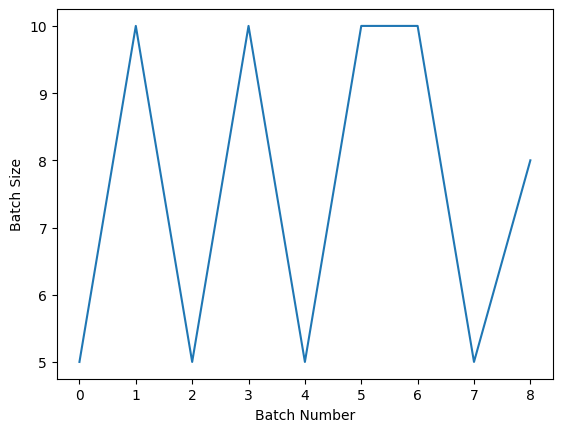

In [26]:
# Plot Batch Size against Batch Number
plt.plot(batch_sizes)
plt.ylabel('Batch Size')
plt.xlabel('Batch Number')
plt.show()

## Label Summary Statistics

In [37]:
labeled_df = pd.DataFrame(all_labeled_data, columns=["Text", "Label"])
labeled_df["Label"].value_counts()

Label
NEU    38
OTR    16
PRS     7
REP     4
Name: count, dtype: int64

## Save labeled data as csv file

In [ ]:
labeled_df.to_csv("labeled_data.csv", index=False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Appendix: Step by Step Workflow To Understand How it Works 

In [14]:
# Assuming you have an instance of OpenAIAssistantManager as assistant_manager
lines = read_csv('data/009-1.csv')

In [17]:
assistant_manager.create_thread("")

Thread(id='thread_EP2OnI2OjhOgK0hNkRSzlBmv', created_at=1702257975, metadata={}, object='thread')

In [18]:
assistant_manager.submit_message(lines[0])
response_page = assistant_manager.get_response()
messages = [msg for msg in response_page] 
assistant_message = messages[-1].content[0].text.value
label = assistant_message.split()[-1]

Run(id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', cancelled_at=None, completed_at=1702257978, created_at=1702257977, expires_at=None, failed_at=None, file_ids=[], instructions='You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\n                                            assistant: PRS\n                                            user: "You need to keep quiet while someone else is 

In [20]:
response_page

SyncCursorPage[ThreadMessage](data=[ThreadMessage(id='msg_UOBcifBcBqUNC09AnRkmZwFX', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=''), type='text')], created_at=1702257975, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'), ThreadMessage(id='msg_juR6FX501z4WJsMpoYKICF6Q', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Good morning class, today we are going to learn about nouns.'), type='text')], created_at=1702257977, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'), ThreadMessage(id='msg_zm20h3opeV17gdNH5RZ79Piv', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', content=[MessageContentText(text=Text(annotations=[], value='NEU'), type='text')], created_at=1702257978, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', thread_

In [22]:
messages 

[ThreadMessage(id='msg_UOBcifBcBqUNC09AnRkmZwFX', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=''), type='text')], created_at=1702257975, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'),
 ThreadMessage(id='msg_juR6FX501z4WJsMpoYKICF6Q', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Good morning class, today we are going to learn about nouns.'), type='text')], created_at=1702257977, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'),
 ThreadMessage(id='msg_zm20h3opeV17gdNH5RZ79Piv', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', content=[MessageContentText(text=Text(annotations=[], value='NEU'), type='text')], created_at=1702257978, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', thread_id='thread_EP2OnI2OjhOgK0hNkRSzlB

In [23]:
messages[-1].content[0].text.value

'NEU'

In [ ]:
user_message = line
# Assuming the last message is from the assistant and contains the label
assistant_message = messages[-1].content[0].text.value
label = assistant_message.split()[-1]

In [29]:
process_lines(lines[0:5], assistant_manager)

[('Good morning class, today we are going to learn about nouns.', 'NEU'),
 ('A noun is a word that represents a person, place, thing, or idea.', 'NEU'),
 ('Can anyone give me an example of a noun?', 'NEU'),
 ("That's right, 'dog' is a noun because it is a thing.", 'NEU'),
 ("Let's write down some nouns in our notebooks.", 'NEU')]

In [10]:
# need to make this a group and feed in x number of lines at a time increasing the beatch size along with the accuracy
messages1 = process_lines(lines[0:5], assistant_manager)


In [11]:
messages1

[('Good morning class, today we are going to learn about nouns.', 'NEU'),
 ('A noun is a word that represents a person, place, thing, or idea.', 'NEU'),
 ('Can anyone give me an example of a noun?', 'OTR'),
 ("That's right, 'dog' is a noun because it is a thing.", 'PRS'),
 ("Let's write down some nouns in our notebooks.", 'OTR')]

In [12]:
df1 = pd.DataFrame(messages1, columns=["Text", "Label"])

In [13]:
# need to make this interactive and feed in the label and then make it available for download as a csv
df1

,Text,Label
0,"Good morning class, today we are going to lear...",NEU
1,"A noun is a word that represents a person, pla...",NEU
2,Can anyone give me an example of a noun?,OTR
3,"That's right, 'dog' is a noun because it is a ...",PRS
4,Let's write down some nouns in our notebooks.,OTR


In [14]:
thread, completed_run = assistant_manager.create_thread_and_run(""" 
Great. Here are some more examples of how to classify utterances::

user: Good morning class, today we are going to learn about nouns.
assistant: NEU
user: A noun is a word that represents a person, place, thing, or idea.
assistant: NEU
user: "Can anyone give me an example of a noun?"
assistant: OTR
user: That's right, 'dog' is a noun because it is a thing.
assistant: PRS

I am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU
""" )


In [15]:
# Wait for the response and get it
response_page_2 = assistant_manager.get_response()

# Collect all messages from the response page
messages2 = [msg for msg in response_page_2]

In [16]:
assistant_message_2 = messages2[-1].content[0].text.value

In [17]:
assistant_message_2

'Understood, go ahead and provide the sentences.'

In [18]:
messages_3 = process_lines(lines[5:10], assistant_manager)

In [19]:
messages_3

[("Now, let's talk about verbs. Does anyone know what a verb is?", 'OTR'),
 ('A verb is a word that describes an action, occurrence, or state of being.',
  'NEU'),
 ('Can someone give me an example of a verb?', 'OTR'),
 ("Great example, 'run' is a verb because it is an action.", 'PRS'),
 ("Now, let's write down some verbs in our notebooks.", 'OTR')]

In [20]:
df3 = pd.DataFrame(messages_3, columns=["Text", "Label"])

In [21]:
df3

,Text,Label
0,"Now, let's talk about verbs. Does anyone know ...",OTR
1,"A verb is a word that describes an action, occ...",NEU
2,Can someone give me an example of a verb?,OTR
3,"Great example, 'run' is a verb because it is a...",PRS
4,"Now, let's write down some verbs in our notebo...",OTR


In [22]:
thread, completed_run = assistant_manager.create_thread_and_run(""" 
Great. Here are some more examples of how to classify utterances:

user: Can someone give me an example of a pronoun?
assistant: OTR
user: That's right, 'he' is a pronoun because it can take the place of a noun.
assistant: PRS
user: "You need to keep quiet while someone else is reading."
assistant: REP
user: A pronoun is a word that can take the place of a noun.
assistant: NEU
user: I don't appreciate the talking while I am teaching; please show some respect.
assistant: REP
user: Good answer, cactus plants have adapted to survive in arid environments by storing water in their stems..
assistant: PRS
user: "Before we end, does anyone have any questions?"
assistant: OTR
user: Next class, we will discuss our observations from the experiment.
assistant: NEU

I am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU
""" )

In [23]:
response_page_4 = assistant_manager.get_response()

# Collect all messages from the response page
messages4 = [msg for msg in response_page_4]

In [24]:
messages4

[ThreadMessage(id='msg_jvPaVvNZN4CKkPUgkKbM7sRk', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=' \nGreat. Here are some more examples of how to classify utterances:\n\nuser: Can someone give me an example of a pronoun?\nassistant: OTR\nuser: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\nassistant: PRS\nuser: "You need to keep quiet while someone else is reading."\nassistant: REP\nuser: A pronoun is a word that can take the place of a noun.\nassistant: NEU\nuser: I don\'t appreciate the talking while I am teaching; please show some respect.\nassistant: REP\nuser: Good answer, cactus plants have adapted to survive in arid environments by storing water in their stems..\nassistant: PRS\nuser: "Before we end, does anyone have any questions?"\nassistant: OTR\nuser: Next class, we will discuss our observations from the experiment.\nassistant: NEU\n\nI am going to provide several more sentences. Only answer with the following thr

In [25]:
messages_5 = process_lines(lines[11:20], assistant_manager)

In [26]:
messages_5

[('An adjective is a word that describes a noun.', 'NEU'),
 ('Can someone give me an example of an adjective?', 'OTR'),
 ("Exactly, 'beautiful' is an adjective because it describes a noun.", 'PRS'),
 ("Let's write down some adjectives in our notebooks.", 'OTR'),
 ('Now we are going to form sentences using nouns, verbs, and adjectives.',
  'OTR'),
 ('A sentence is a group of words that expresses a complete thought.', 'NEU'),
 ("Let's build a sentence together. I'll start with a noun: 'The cat'.",
  'OTR'),
 ('Can someone add a verb to our sentence?', 'OTR'),
 ("Great, now our sentence is: 'The cat runs'.", 'NEU')]

In [27]:
df5 = pd.DataFrame(messages_5, columns=["Text", "Label"])

In [28]:
df5

,Text,Label
0,An adjective is a word that describes a noun.,NEU
1,Can someone give me an example of an adjective?,OTR
2,"Exactly, 'beautiful' is an adjective because i...",PRS
3,Let's write down some adjectives in our notebo...,OTR
4,Now we are going to form sentences using nouns...,OTR
5,A sentence is a group of words that expresses ...,NEU
6,Let's build a sentence together. I'll start wi...,OTR
7,Can someone add a verb to our sentence?,OTR
8,"Great, now our sentence is: 'The cat runs'.",NEU


**Old Functions - keeping until we submit this just in case we need to refer back to them** 

In [ ]:
# def process_lines(lines, assistant_manager):
#     data = []
#     for line in lines:
#         thread, completed_run = assistant_manager.create_thread_and_run(line)
        
#         # Wait for the response and get it
#         response_page = assistant_manager.get_response()

#         # Collect all messages from the response page
#         messages = [msg for msg in response_page]  # Iterating over the response page to collect messages

#         # Extract the user message and the assistant's label
#         if messages:
#             user_message = line
#             # Assuming the last message is from the assistant and contains the label
#             assistant_message = messages[-1].content[0].text.value
#             label = assistant_message.split()[-1]  # Extract label
#             data.append((user_message, label))

#     return data

# def process_lines(lines, assistant_manager, context = ""):
#     data = []
#     assistant_manager.create_thread(context)
#     for line in lines:
#         completed_run = assistant_manager.submit_message(line)
#         response_page = assistant_manager.get_response()
#         messages = [msg for msg in response_page] 
#         assistant_message = messages[-1].content[0].text.value
#         label = assistant_message.split()[-1]

#         data.append((line, label))

#     return data
# def process_lines_in_batches(lines, assistant_manager, batch_size=10):
#     batched_data = []
#     for i in range(0, len(lines), batch_size):
#         batch = lines[i:i + batch_size]
#         batched_data.extend(process_lines(batch, assistant_manager))
#     return batched_data

# def process_lines(lines, assistant_manager, context = ""):
#     data = []
#     assistant_manager.create_thread(context)
#     for line in lines:
#         completed_run = assistant_manager.submit_message(line)
        
#         assistant_manager.submit_message(lines[0])
#         response_page = assistant_manager.get_response()
#         messages = [msg for msg in response_page] 
#         assistant_message = messages[-1].content[0].text.value
#         label = assistant_message.split()[-1]

#         data.append((line, label))

#     return data


In [ ]:
# def label_data(user_input):
#     # This function should take user input and return the labeled data
#     # For simplicity, assume the user inputs the correct label directly
#     return user_input

# def get_predictions_with_context(context, new_data, assistant_manager):
#     predictions = []
#     for data in new_data:
#         prompt = context + f"\n\n{data}"
#         print(f"Sending prompt: {prompt}")  # Debugging line
#         thread, completed_run = assistant_manager.create_thread_and_run(prompt)
#         response_page = assistant_manager.get_response()
#         messages = [msg for msg in response_page]
#         print(f"Received messages: {messages}")  # Debugging line
#         if messages:
#             prediction = messages[-1].content[0].text.value.split()[-1]
#             predictions.append(prediction)
#     return predictions


# def interactive_labeling_loop(initial_data, unlabeled_data, assistant_manager):
#     context = ""
#     batch_size = 5  # Start with 5
#     all_labeled_data = []

#     # Start with initial data for context
#     for data in initial_data:
#         label = label_data(data)
#         context += f"\n{data}: {label}"
#         all_labeled_data.append((data, label))

#     # Loop through unlabeled data in batches
#     for i in range(0, len(unlabeled_data), batch_size):
#         batch = unlabeled_data[i:i + batch_size]
#         predictions = get_predictions_with_context(context, batch, assistant_manager)

#         # User reviews and corrects predictions
#         for data, prediction in zip(batch, predictions):
#             print(f"Predicted for '{data}': {prediction}")
#             correct_label = label_data(data)
#             context += f"\n{data}: {correct_label}"
#             all_labeled_data.append((data, correct_label))

#         # function to increase batch size based on accuracy or other criteria
#         # def increase_batch_size(batch_size, accuracy):
#         # if accuracy > 0.9:
#         # batch_size += 5
#         # if accuracy > 0.95:
#         # batch_size += 5
#         # return batch_size

#         # Increase batch size based on accuracy
#         # batch_size = increase_batch_size(batch_size, accuracy)

#         # Re-train the model
#         # ...

#         # Get the accuracy
#         # accuracy = get_accuracy()
#         # print(f"Accuracy: {accuracy}")

#         # Export the labeled data
#         # export_to_csv(all_labeled_data, "labeled_data.csv")
#         # ...

#     return all_labeled_data

# # Example usage
# # initial_data = [...]  # Your initial 5 sentences
# # unlabeled_data = [...]  # The rest of your data
# # all_labeled_data = interactive_labeling_loop(initial_data, unlabeled_data, assistant_manager)

# # function to process the data in batches
# def process_lines_in_batches(lines, assistant_manager, batch_size=10):
#     batched_data = []
#     for i in range(0, len(lines), batch_size):
#         batch = lines[i:i + batch_size]
#         batched_data.extend(process_lines(batch, assistant_manager))
#     return batched_data

In [ ]:
# #for i in range(0, len(unlabeled_data), batch_size):
# i = 0

# # The while loop iterates through the unlabeled_data array in batches. The loop continues until all items in unlabeled_data have been processed.

# while i < len(unlabeled_data):   
#     if i >= len(unlabeled_data):
#         break

#     # Determine the end index for the current batch
#     end_of_batch = min(i + batch_size, len(unlabeled_data)) 

#     # Extracts a subset from unlabeled_data as the current batch
#     batch = unlabeled_data[i:end_of_batch]
#     batch_sizes.append(batch_size)

#     #Generates predictions for each line in the batch
#     predictions = process_lines(batch, assistant_manager, context = context)  # Get predictions
#     correct_responses = 0

#     # For each prediction, the user is asked to verify or correct the label.
#     for text, prediction in predictions:
#         print(f"Predicted for '{text}': {prediction}")
#         time.sleep(1) 
#         user_decision = input(f"Do you agree with this label? (Y/N): ")

#         #If the user disagrees with the prediction, they are prompted to provide the correct label
#         if user_decision.lower() != 'y':
#             correct_label = label_data(text) 
#         else:
#             # Updates the count of correct responses if the prediction matches the user-provided label
#             correct_label = prediction

#         if correct_label == prediction:
#             correct_responses += 1

#         # Context is updated with the user's input and the correct label. This helps in maintaining a conversation history for context-aware processing in subsequent batches.
#         context += f"\nuser: '{text}'\nassistant: '{correct_label}'"
#         all_labeled_data.append((text, correct_label))
    
#     accuracy = correct_responses / batch_size
#     accuracy_scores.append(accuracy)

#     # Optionally adjusts the batch size based on the accuracy of the current batch
#     batch_size = increase_batch_size(batch_size, accuracy)

#     # Moves the index to the next batch.
#     i += batch_size

# print(f"Accuracy: {accuracy}")